<a href="https://colab.research.google.com/github/daehyun1023/Predict-similarity-between-two-questions/blob/master/quora_malstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="center">

---


  <td>
    <a target="_blank" href="https://github.com/sdtrd011/QuoraQuestionPairs/blob/master/quora_malstm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Import Modules

In [0]:
!pip install glove_python

In [0]:
!pip install keras-rectified-adam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=37f8393fbb22584a4286383f7b8863b2100a7d6a8bf3c020c85925631b5df320
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam


In [0]:
import os
import re
import numpy as np
import pandas as pd
from time import time

import matplotlib
import matplotlib.pyplot as plt

# Text Pre-processing 
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Word Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from glove import Glove, Corpus
from keras.preprocessing.sequence import pad_sequences

# Pipline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# MaLSTM
import tensorflow as tf
from keras import initializers
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Layer
from tensorflow.python.keras import backend as K
from keras_radam import RAdam

# Model evaluation
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load Data

In [0]:
os.getcwd()

'/content'

In [0]:
hw_dir = "drive/My Drive/ML-project"

os.chdir(hw_dir)

In [0]:
os.getcwd()

'/content/drive/My Drive/ML-project'

In [0]:
df = pd.read_csv("./data/train.csv", index_col="id")
df.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Remove Rows with Missing Data

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404290 entries, 0 to 404289
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404290 non-null  int64 
 1   qid2          404290 non-null  int64 
 2   question1     404289 non-null  object
 3   question2     404288 non-null  object
 4   is_duplicate  404290 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 18.5+ MB


In [0]:
df.loc[df.question1.isnull() | df.question2.isnull(), :]

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
105780,174363,174364,How can I develop android app?,NaN,0
201841,303951,174364,How can I create an Android app?,NaN,0
363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [0]:
df = df.dropna(axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404287 non-null  int64 
 1   qid2          404287 non-null  int64 
 2   question1     404287 non-null  object
 3   question2     404287 non-null  object
 4   is_duplicate  404287 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 18.5+ MB


In [0]:
df.is_duplicate.sum() / df.shape[0]

0.3692005926482919

## EDA

In [0]:
df.is_duplicate.value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

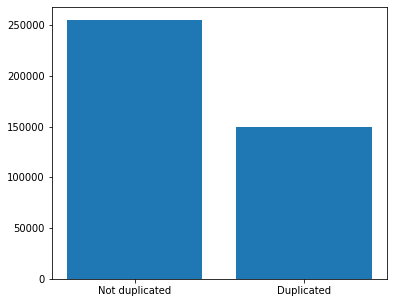

In [0]:
plt.figure(figsize = (6, 5))
plt.bar(["Not duplicated", "Duplicated"], df.is_duplicate.value_counts())
plt.show()

# Word2Vec

In [0]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
w2v_embedding_file = './data/GoogleNews-vectors-negative300.bin'
glove_embedding_file='./data/glove.6B.300d.txt'

## Text Pre-processing

In [0]:
class Text_Pre(BaseEstimator, TransformerMixin):

  def __init__(self, use_wh = False):
    self.use_wh = use_wh

  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):

    # Data Cleaning & Normalization
    X = X.apply(lambda text: re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text))
    X = X.apply(lambda text: re.sub(r"e - mail", "email", text))
    X = X.apply(lambda text: re.sub(r"what's", "what is ", text))
    X = X.apply(lambda text: re.sub(r"\'ve", " have ", text))
    X = X.apply(lambda text: re.sub(r"can't", "can not", text))
    X = X.apply(lambda text: re.sub(r"n't", " not ", text))
    X = X.apply(lambda text: re.sub(r"i'm", "i am ", text))
    X = X.apply(lambda text: re.sub(r"\'re", " are ", text))
    X = X.apply(lambda text: re.sub(r"\'d", " would ", text))
    X = X.apply(lambda text: re.sub(r"\'ll", " will ", text))
    
    # Tokenize
    X = X.apply(lambda text: text_to_word_sequence(text))

    # Stopwords
    org = set(stopwords.words("english"))
    stops = org.difference(set(["no", "not", "nor"]))
    if self.use_wh :
      wh = set(["what", "which", "when", "where", "who", "whom", "whose", "why", "whether", "how"])
      stops= stops.difference(wh) 
    X = X.apply(lambda text: [w for w in text if not w in stops])
    
    # Lemmatization
    lm = WordNetLemmatizer()
    X = X.apply(lambda text: [lm.lemmatize(word) for word in text])

    return X

In [0]:
class Text_W2V(BaseEstimator, TransformerMixin):

  def __init__(self, pretrain = True, max_len = None):
    self.pretrain = pretrain
    self.max_seq = max_len

  def fit(self, X, y = None):
    # Make dictionary for mapping {word : index}
    tk = Tokenizer()
    tk.fit_on_texts(X) 
    self.word_index_ = tk.word_index

    # Mapping the words to the index & Zero Padding
    sequences = tk.texts_to_sequences(X)
    self.data_ = pad_sequences(sequences, maxlen = self.max_seq)

    return self
  
  def transform(self, X, y = None):
    global w2v_embedding_file

    # Word2Vec
    text_w2v = list(X)
    model = Word2Vec(text_w2v, size=300, window=3, min_count=1, workers=1)

    # Intersect with pre-trained model
    if self.pretrain:
      model.intersect_word2vec_format(fname=w2v_embedding_file, binary=True, lockf = 1.0)

    # Result of Word2Vec
    word_vectors = model.wv
    vocabs= word_vectors.vocab.keys()

    # Embedding
    nword = len(vocabs)+1
    embedding_matrix = np.zeros((nword, 300))
    for word, i in self.word_index_.items():
      if word in vocabs:
          embedding_matrix[i] = word_vectors[word]
    print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0)) # It should be 1
    return self.data_, embedding_matrix

In [0]:
class Text_GLOVE(BaseEstimator, TransformerMixin):

  def __init__(self):
    pass

  def fit(self, X, y = None):
    tk = Tokenizer()
    tk.fit_on_texts(X) 
    self.word_index_ = tk.word_index

    # Mapping the words to the index & Zero Padding
    sequences = tk.texts_to_sequences(X)
    self.data_ = pad_sequences(sequences, maxlen=30)

    return self

  def transform(self, X, y = None):
    global glove_embedding_file

    # 사전학습된 glove 파일 읽어오기
    embedding_dict = dict()
    f = open(glove_embedding_file, encoding="utf8")
    for line in f:
      word_vector = line.split()
      word = word_vector[0]
      word_vector_arr = np.asarray(word_vector[1:], dtype='float32') 
      embedding_dict[word] = word_vector_arr
    f.close()

    # Embedding
    q_vocab_size=len(self.word_index_)+1
    q_embedding_matrix=np.zeros((q_vocab_size, 300))
    
    for i in self.word_index_:
      temp=embedding_dict.get(i)
      if temp is not None:
        q_embedding_matrix[self.word_index_[i]]=temp

    return q_vocab_size, self.data_, q_embedding_matrix

## Integer Encoding & Word Embedding (Word2Vec, GloVe)

In [0]:
class Text_EMB(BaseEstimator, TransformerMixin):

  def __init__(self, pretrain = True, max_len = None, method = "word2vec"):
    self.pretrain = pretrain
    self.max_seq = max_len
    self.method = method

  def fit(self, X, y = None):
    # Make dictionary for mapping {word : index}
    tk = Tokenizer()
    tk.fit_on_texts(X) 
    self.word_index_ = tk.word_index

    # Mapping the words to the index & Zero Padding
    sequences = tk.texts_to_sequences(X)
    self.data_ = pad_sequences(sequences, maxlen = self.max_seq)

    return self
  
  def transform(self, X, y = None):
    
    # Word2Vec
    if self.method == "word2vec":
      global w2v_embedding_file

      text_w2v = list(X)
      model = Word2Vec(text_w2v, size=300, window=3, min_count=1, workers=1)

      # Intersect with pre-trained model
      if self.pretrain:
        model.intersect_word2vec_format(fname=w2v_embedding_file, binary=True, lockf = 1.0)

      # Result of Word2Vec
      word_vectors = model.wv
      vocabs= word_vectors.vocab.keys()

      # Embedding
      nword = len(vocabs)+1
      embedding_matrix = np.zeros((nword, 300))
      for word, i in self.word_index_.items():
        if word in vocabs:
            embedding_matrix[i] = word_vectors[word]
      print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0)) # It should be 1

    # GloVe
    if self.method == "glove":
      global glove_embedding_file

      corpus = Corpus()
      corpus.fit(test1, window = 5)
      glove=Glove(no_components=300,learning_rate=0.05)
      glove.fit(corpus.matrix, epochs=30,no_threads=4,verbose=False)
      embedding_matrix = np.concatenate([np.zeros(300).reshape(1, 300), glove.word_vectors])

      if self.pretrain:
        global glove_embedding_file

        # 사전학습된 glove 파일 읽어오기
        embedding_dict = dict()
        f = open(glove_embedding_file, encoding="utf8")
        for line in f:
          word_vector = line.split()
          word = word_vector[0]
          word_vector_arr = np.asarray(word_vector[1:], dtype='float32') 
          embedding_dict[word] = word_vector_arr
        f.close()

        # Embedding
        nword = len(self.word_index_)+1
    
        for word, i in self.word_index_.items():
          if word in embedding_dict.keys():
            embedding_matrix[i] = embedding_dict[word]

    return self.data_, embedding_matrix

In [0]:
quest1 = df.iloc[:, 2]
quest2 = df.iloc[:, 3]
label = df.iloc[:, 4].values

In [0]:
org_len = len(quest1)
print(org_len)

404287


In [0]:
# Combine quest1 & quest2
quest = quest1.append(quest2)
print(len(quest)) # It must be 2 times org_len

808574


In [0]:
def my_pipe(data, use_wh, pretrain, max_len, method):
  pipe = Pipeline([
                   ('Pre-processing', Text_Pre(use_wh = use_wh)),
                   ('Embedding', Text_EMB(pretrain = pretrain, max_len = max_len, method = method))
  ])
  map_data, embd_mat = pipe.fit_transform(data)
  
  n = int(len(data) / 2 )
  data1 = map_data[:n]
  data2 = map_data[n:]

  return data1, data2, embd_mat

In [0]:
tp = Text_Pre(use_wh = True)
t = tp.fit_transform(quest)

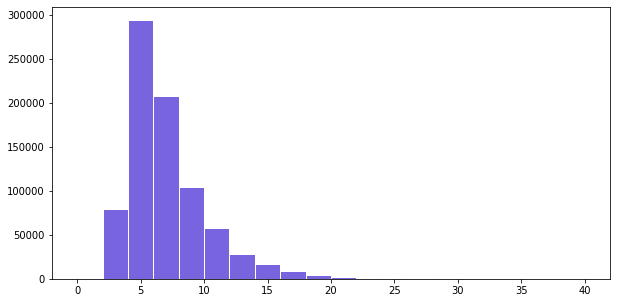

In [0]:
plt.figure(figsize = (10, 5))
plt.hist(t.apply(len).values,bins = 20, range = (0, 40), color = "#7864DF", edgecolor = "white")
plt.show()

In [0]:
print("""
Mininum length of questions : %d
Maximum length of quetions : %d
Mean length of questions : %.2f
Median length of questions : %.2f
"""%((t.apply(len).values).min(), (t.apply(len).values).max(), (t.apply(len).values).mean(), np.median(t.apply(len).values)))


Mininum length of questions : 0
Maximum length of quetions : 110
Mean length of questions : 6.57
Median length of questions : 6.00



# Modeling

## Train-Test Split

In [0]:
def my_split(X1, X2, y, test_size=0.3, random_state=1):
  
  test_num = int(X1.shape[0] * test_size)
  train_num = X1.shape[0] - test_num

  np.random.seed(random_state)
  idx = np.random.permutation(X1.shape[0])

  X1 = X1[idx]
  X2 = X2[idx]
  y = y[idx]

  X1_train = X1[:train_num]
  X2_train = X2[:train_num]
  y_train = y[:train_num]

  X1_test = X1[train_num:]
  X2_test = X2[train_num:]
  y_test = y[train_num:]

  return X1_train, X2_train, y_train, X1_test, X2_test, y_test

## MaLSTM

In [0]:
class ManDist(Layer):
    """
    Keras Custom Layer that calculates Manhattan Distance.
    """

    # initialize the layer, No need to include inputs parameter!
    def __init__(self, **kwargs):
        self.result = None
        super(ManDist, self).__init__(**kwargs)

    # input_shape will automatic collect input shapes to build layer
    def build(self, input_shape):
        super(ManDist, self).build(input_shape)

    # This is where the layer's logic lives.
    def call(self, x, **kwargs):
        self.result = K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True))
        return self.result

    # return output shape
    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)

In [0]:
def modeling(embedding_matrix, n_hidden, bias_init, opt='Adadelta', max_len=30, summary = True):
  
  x=Sequential()

  x.add(Embedding(embedding_matrix.shape[0], 300,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False))

  x.add(LSTM(n_hidden, 
             bias_initializer=initializers.Constant(bias_init)))

  shared_model=x

  left_input = Input(shape=(max_len,), dtype='int32')
  right_input = Input(shape=(max_len,), dtype='int32')

  malstm_distance = ManDist()([shared_model(left_input), shared_model(right_input)])
  model = Model(inputs=[left_input, right_input], outputs=[malstm_distance])
  if opt=='Adadelta':
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adadelta(), metrics=['accuracy'])  
  elif 'Adam':
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
  elif 'Momemtum':
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Momemtum(), metrics=['accuracy'])
  elif 'SGD':
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
  elif 'RAdam':
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RAdam(), metrics=['accuracy'])

  if summary :
    model.summary()
  return model

In [0]:
# Prameters for data
use_whs = [True, False]
pretrains = [True, False]
max_lens=[20, 30, 50]
methods = ['word2vec', 'glove']

# Prameters for model
batch_sizes = [500,1000]
n_epochs = [15,30]
n_hiddens = [10,15,30, 50]
opts=['Adadelta','Adam','SGD', 'Momemtum', "RAdam"]
bias_inits = [1.0, 1.5, 2.0, 2.5]

### Apply

In [0]:
# Data parameter setting for Hyewon
use_wh = use_whs[0]
pretrain = use_whs[0]
max_len = max_lens[0]
method = methods[0]

print("--------------Check your parameter setting---------------")
print("Using wh- words:", use_wh)
print("Using pretrained word2vec model:", pretrain)
print("Maximum length of questions:", max_len)
print("Word embedding method:", method)
print("---------------------------------------------------------")

# data
d1, d2, e1 = my_pipe(quest, use_wh = use_wh, pretrain = pretrain, max_len = max_len, method = method)
q1_train, q2_train, y_train, q1_test, q2_test, y_test = my_split(d1, d2, label, random_state = 1234)

--------------Check your parameter setting---------------
Using wh- words: True
Using pretrained word2vec model: True
Maximum length of questions: 20
---------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Null word embeddings: 1


In [0]:
# Model parameter setting for Hyewon

n_hidden = 50
opt = "Adam"
bias_init = 2.0

print("--------------Check your parameter setting---------------")
print("Dimmension of hidden layer: ", n_hidden )
print("Initial value of biase:", bias_init)
print("Optimizer: ", opt)
print("Maximum length of questions: ", max_len)
print("---------------------------------------------------------")

model=modeling(e1, n_hidden = n_hidden, bias_init = bias_init, opt = opt, max_len = max_len)

--------------Check your parameter setting---------------
Dimmension of hidden layer:  50
Initial value of biase: 2.0
Optimizer:  Adam
Maximum length of questions:  20
---------------------------------------------------------
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 50)           25315500    input_1[0][0]                    
                                                                 i

In [0]:
# Result under the setting of Hyewon
batch_size = batch_sizes[0]
n_epoch = 50

print("--------------Check your parameter setting---------------")
print("Batch size:", batch_size )
print("Number of epoch:", n_epoch)
print("---------------------------------------------------------")

# model
training_start_time = time()
malstm_trained = model.fit([q1_train, q2_train], y_train,
                           batch_size=batch_size, epochs= n_epoch,
                           validation_split = 0.2)
training_end_time = time()
print(
"""Training is finished. Check the parameter settings again.
[Data parameter settings]
Using wh- words: %s
Using pretrained model: %s
Embedding method: %s
Maximum length of questions: %d

[Model parameter settings]
Dimension of hidden layer: %d
Initial value of bias: %.1f
Optimizer: %s
Maximum length of questions: %d
Batch size: %d
Number of epochs: %d

Training time: %d epochs in %12.2f
"""%
(use_wh, pretrain, meethod, max_len, n_hidden, bias_init, opt, max_len, batch_size, n_epoch, n_epoch, training_end_time - training_start_time))

--------------Check your parameter setting---------------
Batch size: 500
Number of epoch: 50
---------------------------------------------------------
Epoch 1/50
453/453 [==============================] - 6s 12ms/step - loss: 0.6229 - accuracy: 0.7233 - val_loss: 0.5866 - val_accuracy: 0.7378
Epoch 2/50
453/453 [==============================] - 5s 11ms/step - loss: 0.5660 - accuracy: 0.7581 - val_loss: 0.5620 - val_accuracy: 0.7587
Epoch 3/50
453/453 [==============================] - 5s 11ms/step - loss: 0.5481 - accuracy: 0.7716 - val_loss: 0.5494 - val_accuracy: 0.7697
Epoch 4/50
453/453 [==============================] - 5s 11ms/step - loss: 0.5366 - accuracy: 0.7798 - val_loss: 0.5443 - val_accuracy: 0.7712
Epoch 5/50
453/453 [==============================] - 5s 11ms/step - loss: 0.5279 - accuracy: 0.7856 - val_loss: 0.5418 - val_accuracy: 0.7700
Epoch 6/50
453/453 [==============================] - 5s 11ms/step - loss: 0.5201 - accuracy: 0.7909 - val_loss: 0.5339 - val_accurac

In [0]:
model.save('./hwmodel.h5')

hist_df = pd.DataFrame(malstm_trained.history) 

# or save to csv: 
hist_csv_file = './history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.622874,0.723251,0.586648,0.737831
1,0.566050,0.758118,0.561973,0.758732
2,0.548092,0.771617,0.549414,0.769686
3,0.536580,0.779810,0.544261,0.771170
4,0.527934,0.785552,0.541782,0.769969


## Model Evaluation

In [0]:
def my_eval(test1 , test2 , label = y_test):
  y_pred = model.predict([test1,test2])
  y_pred_class = (y_pred > 0.5).astype(np.int)
  test_acc = accuracy_score(y_test, y_pred_class)
  test_prf = precision_recall_fscore_support(y_test, y_pred_class, average = "binary")[:3]

  test_result = list(test_prf)
  test_result.append(test_acc)

  test_df = pd.DataFrame(test_result).T
  test_df.columns = ["Precision", "Recall", "F1-score", "Accuracy"]

  return test_df

In [0]:
model = tf.keras.models.load_model('./hwmodel.h5', custom_objects={'ManDist': ManDist})
model.evaluate([q1_test, q2_test], y_test)
my_eval(q1_test, q2_test) # epoch = 50

3791/3791 [==============================] - 17s 4ms/step - loss: 0.4882 - accuracy: 0.8113


,Precision,Recall,F1-score,Accuracy
0,0.777003,0.686218,0.728794,0.81133


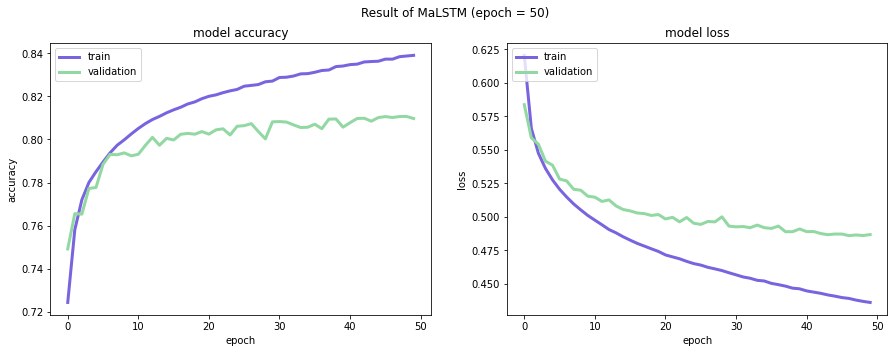

In [0]:
plt.figure(figsize = (15, 5))

plt.suptitle("Result of MaLSTM (epoch = 50)")
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(malstm_trained.history['accuracy'], c = "#7864DF", lw = 3)
plt.plot(malstm_trained.history['val_accuracy'], c = "#92D8A3", lw = 3)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(malstm_trained.history['loss'], c = "#7864DF", lw = 3)
plt.plot(malstm_trained.history['val_loss'], c = "#92D8A3", lw = 3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Compair Optimizer

In [0]:
opts=['Adadelta','Adam','SGD', 'Momemtum', "RAdam"]
n_hidden = 50
bias_init = 2.0
batch_size = 500
n_epoch = 50
max_len = 20

opt_res = pd.DataFrame()
for i in range(len(opts)):
  opt = opts[i]
  print("Training by %s optimizer is Start!" %opt)

  # model
  model=modeling(e12, n_hidden = n_hidden, bias_init = bias_init, opt = opt, max_len = max_len, summary = False)
  malstm_trained = model.fit([q1_train2, q2_train2], y_train,
                            batch_size=batch_size, epochs= n_epoch,
                            validation_split = 0.2, verbose = 0)
  
  # eval
  test_res = my_eval(q1_test2, q2_test2)
  opt_res = pd.concat([opt_res, test_res])

In [0]:
opt_res #ver.hw

,Precision,Recall,F1-score,Accuracy,Optimizer
0,0.598976,0.446669,0.511730,0.685116,Adadelta
0,0.775501,0.696730,0.734008,0.813457,Adam
0,0.775094,0.696953,0.733950,0.813342,SGD
0,0.774026,0.692244,0.730854,0.811652,Momemtum
0,0.766019,0.705189,0.734347,0.811520,RAdam


In [0]:
opt_res.to_csv("./hw_opt_res.csv", index = False)

# Other models

## 2 LSTM Models

In [0]:
## LSTM 따로 한 모델

def each_modeling(embedding_matrix, n_hidden, bias_init = 2.0, opt='Adam', max_len=20):

  left_model=Sequential()
  left_model.add(Embedding(embedding_matrix.shape[0], 300,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False))
  left_model.add(LSTM(n_hidden,bias_initializer=initializers.Constant(bias_init)))

  right_model=Sequential()
  right_model.add(Embedding(embedding_matrix.shape[0], 300,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False))
  right_model.add(LSTM(n_hidden,bias_initializer=initializers.Constant(bias_init)))


  left_input = Input(shape=(max_len,), dtype='int32')
  right_input = Input(shape=(max_len,), dtype='int32')

  malstm_distance = ManDist()([left_model(left_input), right_model(right_input)])
  model = Model(inputs=[left_input, right_input], outputs=[malstm_distance])
  if opt=='Adadelta':
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adadelta(), metrics=['accuracy'])  
  elif 'Adam':
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
  elif 'Momemtum':
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Momemtum(), metrics=['accuracy'])
  elif 'SGD':
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
  elif 'RAdam':
    model.compile(loss='binary_crossentropy', optimizer=Radam(), metrics=['accuracy'])

  model.summary()
  return model


In [0]:
n_hidden = 50
opt = "Adam"
bias_init = 2.0

print("--------------Check your parameter setting---------------")
print("Dimmension of hidden layer: ", n_hidden )
print("Initial value of biase:", bias_init)
print("Optimizer: ", opt)
print("Maximum length of questions: ", max_len)
print("---------------------------------------------------------")

model2 = each_modeling(e1, n_hidden = n_hidden, bias_init = bias_init, opt = opt, max_len = max_len)

--------------Check your parameter setting---------------
Dimmension of hidden layer:  50
Initial value of biase: 2.0
Optimizer:  Adam
Maximum length of questions:  20
---------------------------------------------------------
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50)           25315500    input_3[0][0]                    
________________________________________________________________

In [0]:
batch_size = batch_sizes[0]
n_epoch = 50

print("--------------Check your parameter setting---------------")
print("Batch size:", batch_size )
print("Number of epoch:", n_epoch)
print("---------------------------------------------------------")

# model
training_start_time = time()
malstm_trained2 = model2.fit([q1_train, q2_train], y_train,
                           batch_size=batch_size, epochs= n_epoch,
                           validation_split = 0.2)
training_end_time = time()
print(
"""Training is finished. Check the parameter settings again.
[Data parameter settings]
Using wh- words: %s
Using pretrained word2vec model: %s
Maximum length of questions: %d

[Model parameter settings]
Dimension of hidden layer: %d
Initial value of bias: %.1f
Optimizer: %s
Maximum length of questions: %d
Batch size: %d
Number of epochs: %d

Training time: %d epochs in %12.2f
"""%
(use_wh, pretrain, max_len, n_hidden, bias_init, opt, max_len, batch_size, n_epoch, n_epoch, training_end_time - training_start_time))

--------------Check your parameter setting---------------
Batch size: 500
Number of epoch: 50
---------------------------------------------------------
Epoch 1/50
453/453 [==============================] - 11s 23ms/step - loss: 0.4173 - accuracy: 0.8086 - val_loss: 0.4972 - val_accuracy: 0.7673
Epoch 2/50
453/453 [==============================] - 11s 23ms/step - loss: 0.4162 - accuracy: 0.8088 - val_loss: 0.4941 - val_accuracy: 0.7694
Epoch 3/50
453/453 [==============================] - 10s 23ms/step - loss: 0.4147 - accuracy: 0.8103 - val_loss: 0.4951 - val_accuracy: 0.7688
Epoch 4/50
453/453 [==============================] - 10s 23ms/step - loss: 0.4139 - accuracy: 0.8109 - val_loss: 0.4965 - val_accuracy: 0.7683
Epoch 5/50
453/453 [==============================] - 11s 24ms/step - loss: 0.4135 - accuracy: 0.8109 - val_loss: 0.4934 - val_accuracy: 0.7690
Epoch 6/50
453/453 [==============================] - 10s 23ms/step - loss: 0.4117 - accuracy: 0.8112 - val_loss: 0.4936 - val_a

In [0]:
model2.save('./hwmodel2.h5')

hist_df2 = pd.DataFrame(malstm_trained2.history) 

# or save to csv: 
hist_csv_file2 = './history2.csv'
with open(hist_csv_file2, mode='w') as f:
    gs_hist_df2.to_csv(f)

hist_df2.head()

,loss,accuracy,val_loss,val_accuracy
0,0.417319,0.808573,0.497200,0.767336
1,0.416202,0.808834,0.494080,0.769368
2,0.414727,0.810309,0.495080,0.768767
3,0.413914,0.810883,0.496512,0.768273
4,0.413472,0.810857,0.493366,0.768997


In [0]:
model = tf.keras.models.load_model('./hwmodel2.h5', custom_objects={'ManDist': ManDist})
model.evaluate([q1_test, q2_test], y_test)
my_eval(q1_test, q2_test) # ver.hw

3791/3791 [==============================] - 17s 4ms/step - loss: 0.4554 - accuracy: 0.7859


,Precision,Recall,F1-score,Accuracy
0,0.750007,0.630555,0.685113,0.785878


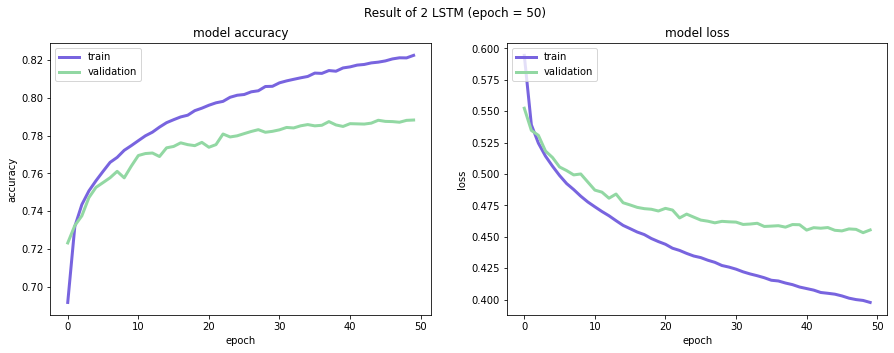

In [0]:
plt.figure(figsize = (15, 5))

plt.suptitle("Result of 2 LSTM (epoch = 50)")
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(malstm_trained2.history['accuracy'], c = "#7864DF", lw = 3)
plt.plot(malstm_trained2.history['val_accuracy'], c = "#92D8A3", lw = 3)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(malstm_trained2.history['loss'], c = "#7864DF", lw = 3)
plt.plot(malstm_trained2.history['val_loss'], c = "#92D8A3", lw = 3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## MaLSTM + DENSE

In [0]:
def dense_modeling(embedding_matrix, n_hidden, n_layer, n_dense, drop = False, bias_init = 2.0, opt='Adam', max_len=20, act = ["relu"], summary = True):
  
  x=Sequential()

  x.add(Embedding(embedding_matrix.shape[0], 300,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False))

  x.add(LSTM(n_hidden, 
             bias_initializer=initializers.Constant(bias_init)))
  
  for i in range(n_layer):
    x.add(Dense(n_dense[i], activation=act[i]))
    if drop :
      x.add(Dropout(0.5))

  shared_model=x

  left_input = Input(shape=(max_len,), dtype='int32')
  right_input = Input(shape=(max_len,), dtype='int32')

  malstm_distance = ManDist()([shared_model(left_input), shared_model(right_input)])
  model = Model(inputs=[left_input, right_input], outputs=[malstm_distance])
  if opt=='Adadelta':
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adadelta(), metrics=['accuracy'])  
  elif 'Adam':
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
  elif 'Momemtum':
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Momemtum(), metrics=['accuracy'])
  elif 'SGD':
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
  elif 'RAdam':
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RAdam(), metrics=['accuracy'])

  if summary :
    model.summary()
  return model

In [0]:
d_model5 = dense_modeling(embedding_matrix = e1, n_hidden = 100, n_layer = 1, n_dense = [10], act = ['relu'])
dense_lstm_trained3 = d_model5.fit([q1_train, q2_train], y_train,
                          batch_size= 500, epochs= 50,
                          validation_split = 0.2)
d_model5.evaluate([q1_test, q2_test], y_test)

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_74 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
sequential_40 (Sequential)      (None, 10)           25406710    input_73[0][0]                   
                                                                 input_74[0][0]                   
__________________________________________________________________________________________________
man_dist_36 (ManDist)           (None, 1)            0           sequential_40[1][0]       

[0.4869118332862854, 0.8227165341377258]

In [0]:
model = d_model5
my_eval(q1_test, q2_test)

,Precision,Recall,F1-score,Accuracy
0,0.811729,0.677157,0.738361,0.822717


In [0]:
d_model5.save('./hwmodel_d10.h5')

hist_df = pd.DataFrame(dense_lstm_trained3.history) 

# or save to csv: 
hist_csv_file = './history_d10.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.667180,0.697871,0.591512,0.739210
1,0.571965,0.753922,0.567961,0.755040
2,0.547067,0.771290,0.546688,0.772142
3,0.529149,0.783891,0.538035,0.778131
4,0.517686,0.791391,0.527693,0.784898


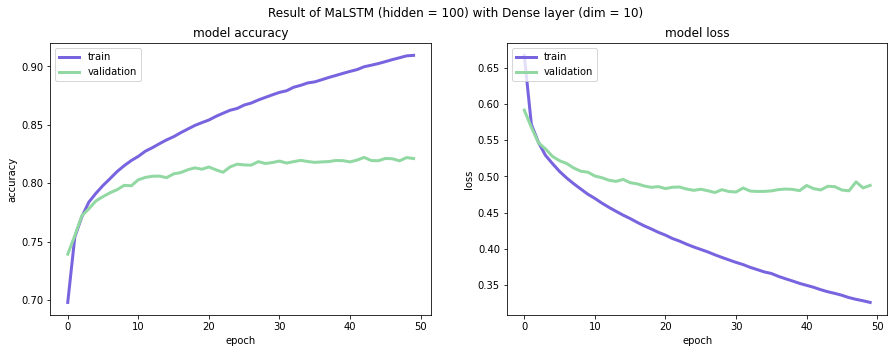

In [0]:
plt.figure(figsize = (15, 5))

plt.suptitle("Result of MaLSTM (hidden = 100) with Dense layer (dim = 10)")
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(dense_lstm_trained3.history['accuracy'], c = "#7864DF", lw = 3)
plt.plot(dense_lstm_trained3.history['val_accuracy'], c = "#92D8A3", lw = 3)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(dense_lstm_trained3.history['loss'], c = "#7864DF", lw = 3)
plt.plot(dense_lstm_trained3.history['val_loss'], c = "#92D8A3", lw = 3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()